In [1]:
import sys
sys.path.append('..')
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
from metpy.units import units

from Map import Map
from Data import Data, ValidTime

In [2]:
'''Define Model Parameters'''
LOCATION = 'texas'
THRESHOLD = 40
MODEL_DATE = '20230610'
CYCLE = '18'
FORECAST_HOUR = '12'

# Define area to retrieve data
LEFT_LON = -110
RIGHT_LON = -80
TOP_LAT = 40
BOTTOM_LAT = 24

In [3]:
PRODUCT_MAPPING = {40: 1, 50: 2}.get(THRESHOLD, 50)
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'models' / 'href'

In [4]:
URL = ('https://nomads.ncep.noaa.gov/cgi-bin/filter_hrefconus.pl?'
              f'file=href.t{CYCLE}z.conus.prob.f{FORECAST_HOUR}.grib2'
              f'&all_lev=on&var_MAXREF=on&subregion='
              f'&leftlon={360 + LEFT_LON}&rightlon={360 + RIGHT_LON}'
              f'&toplat={TOP_LAT}&bottomlat={BOTTOM_LAT}&'
              f'dir=/href.{MODEL_DATE}/ensprod')

ds = Data(URL)
data = ds.pygrib_read_dataset()

In [5]:
#%%capture
reflectivity = data[PRODUCT_MAPPING]

# Extract lats, lons, and data values
lats, lons = reflectivity.latlons()
href_values = reflectivity.values

# Get Valid Local Time
vt = ValidTime(reflectivity.validityDate, reflectivity.validityTime, 'America/Chicago')
VALID_TIME = vt.convert_datetime_pygrib()

In [10]:
txt = str(reflectivity)
threshold = txt.split('> ')[1].split(')')[0].split('.')[0]

In [6]:
def get_gridpoint_value(lat_of_interest: float, lon_of_interest: float) -> int:
    '''
    Calculate the closest gridpoint value to a given latitude
    and longitude.
    '''
    abs_lat = np.abs(lats - lat_of_interest)
    abs_lon = np.abs(lons - lon_of_interest)
    
    overlap_latlon = np.maximum(abs_lon, abs_lat)
    latlon_idx = np.argmin(overlap_latlon)
    
    href_1d = href_values.flatten()
    
    return href_1d[latlon_idx]


ktpa_prob = np.round(get_gridpoint_value(27.9506, -82.4572)).astype(int)
klal_prob = np.round(get_gridpoint_value(28.0395, -81.9498)).astype(int)
ksrq_prob = np.round(get_gridpoint_value(27.3365, -82.5310)).astype(int)
kzph_prob = np.round(get_gridpoint_value(28.3326, -82.1812)).astype(int)
kspg_prob = np.round(get_gridpoint_value(27.7676, -82.6403)).astype(int)
kpie_prob = np.round(get_gridpoint_value(27.9659, -82.8001)).astype(int)

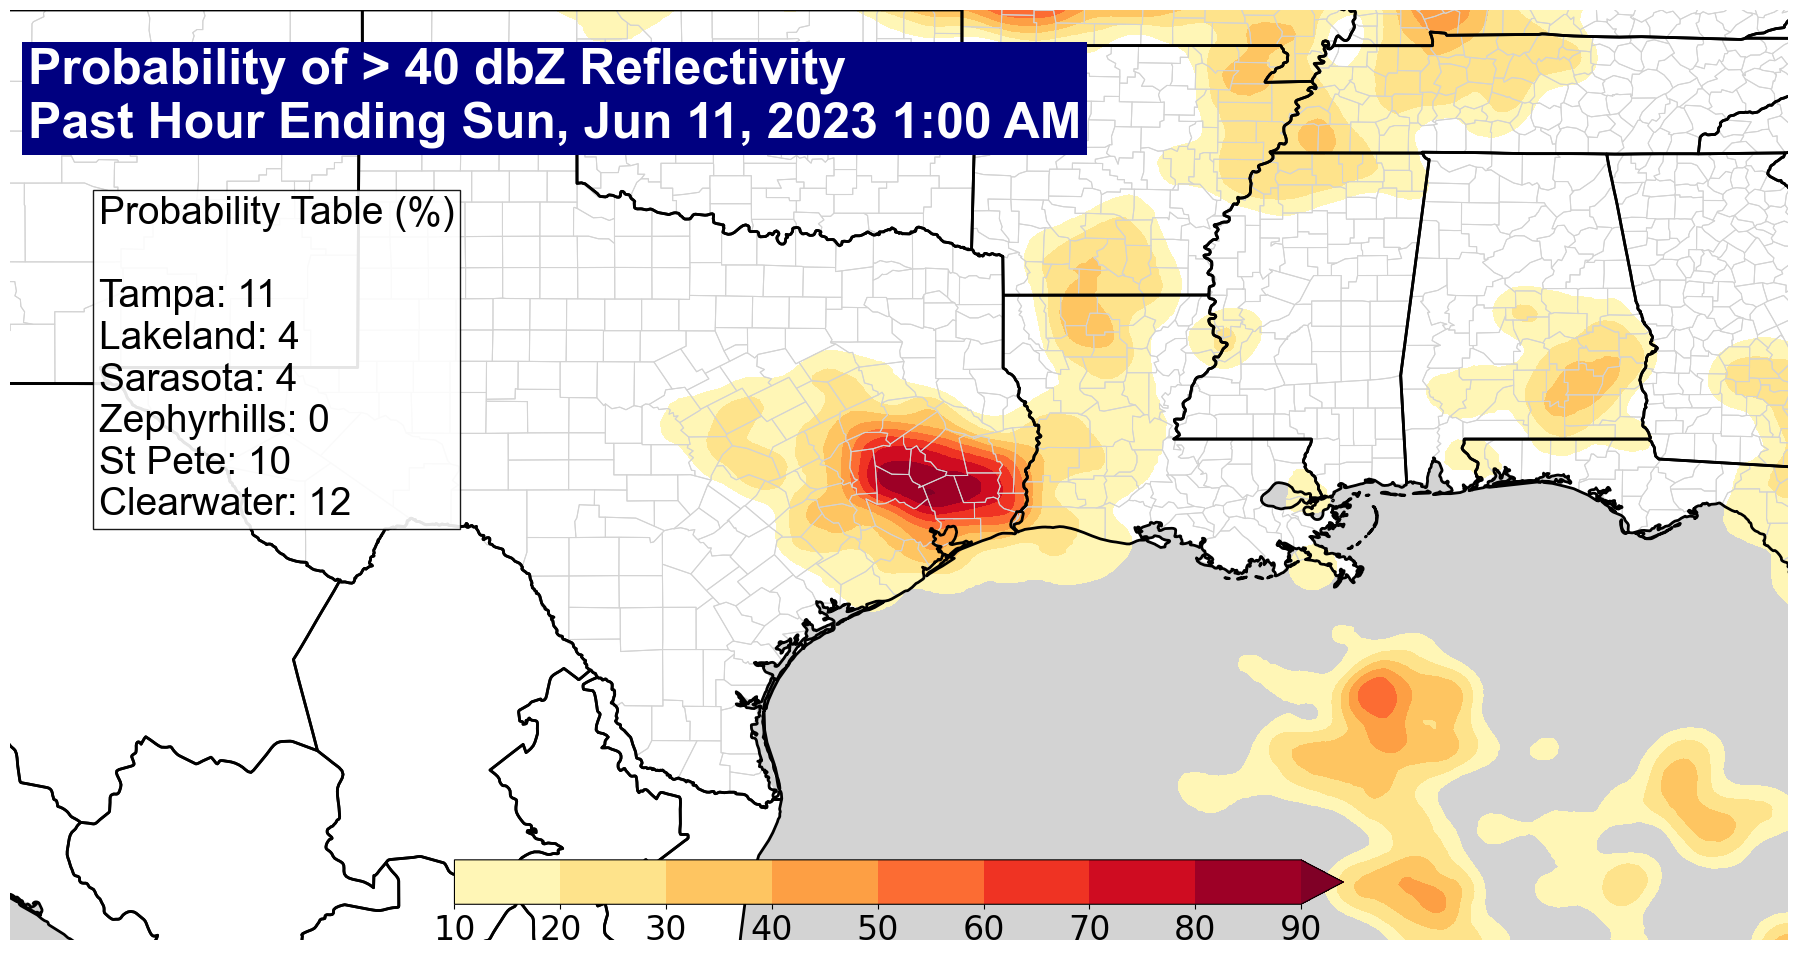

In [13]:
new_map = Map(LOCATION)
new_map.add_counties()
new_map.add_title(f'Probability of > {threshold} dbZ Reflectivity \nPast Hour Ending {VALID_TIME}')

fig, ax = new_map.make_map()

data_range = [num for num in np.arange(10, 100, 10)]
contour = ax.contourf(lons, lats, href_values, data_range, cmap=plt.cm.YlOrRd, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Add probability table
probs = ('Probability Table (%)\n\n'
         f'Tampa: {ktpa_prob}\n'
         f'Lakeland: {klal_prob}\n'
         f'Sarasota: {ksrq_prob}\n'
         f'Zephyrhills: {kzph_prob}\n'
         f'St Pete: {kspg_prob}\n'
         f'Clearwater: {kpie_prob}')

ax.text(0.05, 0.80, s=probs, fontsize=28, bbox=dict(facecolor='white', alpha=0.9), 
         transform=ax.transAxes, zorder=20, verticalalignment='top', fontname='Arial')

# Save and show figure
plt.savefig(f'{graphics_dir}/mxrefd-{threshold}dbz_{FORECAST_HOUR}.png', dpi=72)
plt.show()